### Ranking History
* Zweck: Verbesserung des Ranking Quotienten aus der Replikation anhand der Feature Hisotry Matrizen.
* Matrix: Regressionsmatrix mit Feautre History des mozilla-central Repository
* Features: Includes, Function Calls
* Modell: Support Vector Regressionsmodell

#### Setup
* Training-Set/Test-Set: Stratified sampling auf einer Matrix (2/3 : 1/3)

#### Results
Angenommen man konzentriert seine Ressourcen auf die Optimierung der 1% verwundbarsten Komponenten. Bei der Auswahl verlässt man sich auf die Vorhersage des Regressionsmodells. Dieses Skript berechnet den Faktor zwischen der Anzahl Verwundbarkeiten die in diesem Fall behoben werden und der Anzahl Verwundbarkeiten die bei der Konzentration auf 1% maximal behoben werden können.
* Resultat: Faktor zwischen behobenen und maximal behebbaren Verwundbarkeiten.

0 - f_opt: 893.0, quotient: 0.987681970885
1 - f_opt: 821.0, quotient: 0.990255785627
2 - f_opt: 817.0, quotient: 0.992656058752
3 - f_opt: 865.0, quotient: 0.989595375723
4 - f_opt: 829.0, quotient: 0.977080820265
5 - f_opt: 846.0, quotient: 0.983451536643
6 - f_opt: 850.0, quotient: 0.988235294118
7 - f_opt: 895.0, quotient: 0.989944134078
8 - f_opt: 829.0, quotient: 0.985524728589
9 - f_opt: 829.0, quotient: 0.983112183353
10 - f_opt: 836.0, quotient: 0.988038277512
11 - f_opt: 854.0, quotient: 0.992974238876
12 - f_opt: 804.0, quotient: 0.980099502488
13 - f_opt: 925.0, quotient: 0.982702702703
14 - f_opt: 858.0, quotient: 0.981351981352
15 - f_opt: 795.0, quotient: 0.968553459119
16 - f_opt: 869.0, quotient: 0.968929804373
17 - f_opt: 877.0, quotient: 0.984036488027
18 - f_opt: 792.0, quotient: 0.978535353535
19 - f_opt: 825.0, quotient: 0.991515151515
20 - f_opt: 794.0, quotient: 0.981108312343
21 - f_opt: 817.0, quotient: 0.979192166463
22 - f_opt: 859.0, quotient: 0.97671711292

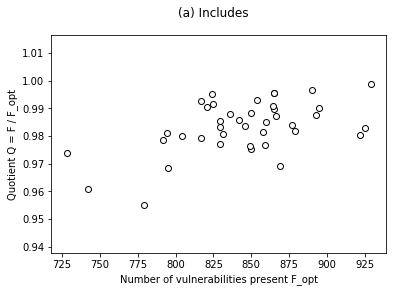

In [18]:
%matplotlib inline

from imports.matrix_helper import MatrixHelper
from imports.prediction_helper import PredictionHelper
import matplotlib.pyplot as plt
import numpy as np

matrix_helper = MatrixHelper()
experiments_count = 40

# read pickle
matrices = matrix_helper.load_from_parse('data/matrices/matrix_reg_incl_history.pickle')

quotient_list = []
f_opt_list = []
for i in range(experiments_count):
    # Instantiate Prediction Helper Class and predict values for compare matrix
    prediction_helper = PredictionHelper()
    prediction_helper.calculate_validation_compare_matrix(matrices, sampling_factor=(2.0/3), model_type='SVR')

    # get the compare matrix twice:
    # Once sorted according to the PREDICTED number of vulnerabilities
    # Once sorted according to the ACTUAL number of vulnerabilities
    compare_matrix_sorted_predicted = prediction_helper.get_compare_matrix_sorted()
    compare_matrix_sorted_actual = prediction_helper.get_compare_matrix_sorted(reference_column=2)

    # Crop first 30 Samples of both matrices
    relevant_samples_count = 30
    compare_matrix_sorted_predicted = compare_matrix_sorted_predicted[range(relevant_samples_count)]
    compare_matrix_sorted_actual = compare_matrix_sorted_actual[range(relevant_samples_count)]

    # Sum up the actual number of vulnerabilities in both matrices
    f = sum(np.array(compare_matrix_sorted_predicted[:, 2], dtype='f'))
    f_opt = sum(np.array(compare_matrix_sorted_actual[:, 2], dtype='f'))
    
    f_opt_list.append(f_opt)
    quotient_list.append(f / f_opt)
    print('{} - f_opt: {}, quotient: {}'.format(i, f_opt, f / f_opt))

# plot
fig = plt.figure()
plt.scatter(f_opt_list, quotient_list, edgecolor='black', linewidth='1', facecolor='white')
fig.suptitle('(a) Includes')
plt.xlabel('Number of vulnerabilities present F_opt')
plt.ylabel('Quotient Q = F / F_opt')
fig.savefig('outputs/f_opt-quotient-includes-history.pdf')

# print
quotient_average = sum(quotient_list) / float(len(quotient_list))
print('Average Quotient of {} Experiments: {}'.format(experiments_count, quotient_average)) 

Includes            : 40/40
Function Calls      : 40/40
+----------------+--------------+-----------------------------+
| Features       | Quotient avg | Quotient standard deviation |
+----------------+--------------+-----------------------------+
| Includes       |     0.96     |            0.020            |
| Function Calls |     0.99     |            0.008            |
+----------------+--------------+-----------------------------+


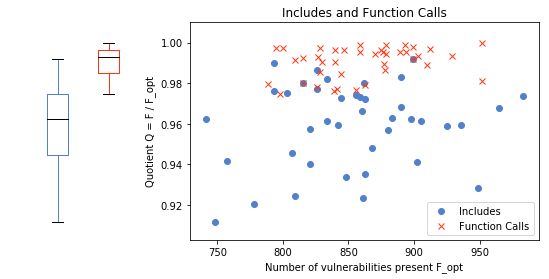

In [1]:
%matplotlib inline

from imports.matrix_helper import MatrixHelper
from imports.prediction_helper import PredictionHelper
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable

matrix_helper = MatrixHelper()
experiments_count = 40

features = [('incl', 'Includes', 'o', '#5180cc'), ('calls', 'Function Calls', 'x', '#FD3612')]
quotient_lists = {}
f_opt_lists = {}

for feature in features:
    # read pickle
    matrices = matrix_helper.load_from_parse('data/matrices/matrix_reg_{}_history.pickle'.format(feature[0]))
    quotient_lists[feature[0]] = []
    f_opt_lists[feature[0]] = []

    for i in range(experiments_count):
        print '{:20}: {:2}/{:2}\r'.format(feature[1], i+1, experiments_count),
        
        # Instantiate Prediction Helper Class and predict values for compare matrix
        prediction_helper = PredictionHelper()
        prediction_helper.calculate_validation_compare_matrix(matrices, sampling_factor=(2.0/3), model_type='SVR')

        # get the compare matrix twice:
        # Once sorted according to the PREDICTED number of vulnerabilities
        # Once sorted according to the ACTUAL number of vulnerabilities
        compare_matrix_sorted_predicted = prediction_helper.get_compare_matrix_sorted()
        compare_matrix_sorted_actual = prediction_helper.get_compare_matrix_sorted(reference_column=2)

        # Crop first 1% of both matrices
        relevant_samples_count = 30 #int(round(0.01 * len(compare_matrix_sorted_predicted)))
        compare_matrix_sorted_predicted = compare_matrix_sorted_predicted[range(relevant_samples_count)]
        compare_matrix_sorted_actual = compare_matrix_sorted_actual[range(relevant_samples_count)]

        # Sum up the actual number of vulnerabilities in both matrices
        f = sum(np.array(compare_matrix_sorted_predicted[:, 2], dtype='f'))
        f_opt = sum(np.array(compare_matrix_sorted_actual[:, 2], dtype='f'))

        f_opt_lists[feature[0]].append(f_opt)
        quotient_lists[feature[0]].append(f / f_opt)
    print

                
ymin = min([min(quotient_lists[list]) for list in quotient_lists])
ymax = max([max(quotient_lists[list]) for list in quotient_lists])

fig = plt.figure(figsize=(9, 4))

for i, feature in enumerate(features):
    ax = plt.subplot2grid((1, 10), (0, i))
    boxprops = dict(color=feature[3])
    flierprops = dict(markerfacecolor=feature[3],markeredgecolor=feature[3], marker=feature[2])
    whiskerprops = dict(color=feature[3])
    medianprops = dict(color='black')
    plt.boxplot(quotient_lists[feature[0]], flierprops=flierprops, whiskerprops=whiskerprops, boxprops=boxprops, medianprops=medianprops, widths=(0.5))
    plt.ylim(ymin=ymin/1.01, ymax=ymax*1.01)
    plt.axis('off')

ax = plt.subplot2grid((1, 10), (0, 3), colspan=7)
for feature in features:
    plt.scatter(f_opt_lists[feature[0]], quotient_lists[feature[0]], edgecolor=feature[3], linewidth='1', facecolor=feature[3], marker=feature[2], label=feature[1])

plt.xlabel('Number of vulnerabilities present F_opt')
plt.ylabel('Quotient Q = F / F_opt')
plt.ylim(ymin=ymin/1.01, ymax=ymax*1.01)
plt.legend(loc=4)
ax.set_title('Includes and Function Calls')

fig.savefig('ranking-history.pdf')
        

# print
print('==================================')
table = PrettyTable(['Features', 'Quotient avg', 'Quotient standard deviation'])
table.align["Features"] = "l"
for feature in features:
    quotient_average = '{:.2f}'.format(sum(quotient_lists[feature[0]]) / float(len(quotient_lists[feature[0]])))
    quotient_sd = '{:.3f}'.format(np.std(quotient_lists[feature[0]]))

    
    table.add_row([feature[1], quotient_average, quotient_sd])
print(table)
print('==================================')

